[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/royforestano/Deep_Learning_Symmetries/blob/main/Discovering_Sparse_Representations_of_Lie_Groups_with_Machine_Learning/sym_u_and_su_tutorial.ipynb)

# Discovering Sparse Representations of Lie Groups with Machine Learning - Tutorial

Author: Roy Forestano

Date of Completion: 18 February 2023

Connected to the paper on: Discovering Sparse Representations of Lie Groups with Machine Learning (arXiv:2302.05383: https://arxiv.org/abs/2302.05383)

Given a dataset with dimension $N$, a neural network can be utilized to modify a random state of generators and structure constants to reproduce the proper entries corresponding to a given group, e.g. SO(N). The model takes in an array of the desired number of generators $N_{g}$ as $N \times N$ matrices and an array of the structure constants with shape $N_{brackets} \times N_{g}$. The model begins by looping over the generators applying a sequential layer to each. The second part loops over the rows of the structure constant array applying a sequential layer to each, which is a generalized modification to the code for a paper on deep learning symmetries [(Forestano et al.)](https://arxiv.org/abs/2301.05638). The model modifies these arrays to produce the desired generators and structure constants with an interconnected loss function, which now minimizes the dispersion between entries. This allows for a more simple visual verification of a group structure and its algebra by enforcing the resulting elements to be in a sparse representation, which may or may not be the canonical form.

## Useful Resources

1. The Quaternions and the Spaces S3, SU(2), SO(3), RP3: https://www.cis.upenn.edu/~cis5150/gma-v2-chap9.pdf
2. Charts on SO(3): https://en.wikipedia.org/wiki/Charts_on_SO(3)
3. Lie Groups as Manifolds SU(2) and Three sphere: http://mf23.web.rice.edu/LA_2_v1.4%20Lie%20groups%20as%20manifolds;%20su(2)%20and%20S3.pdf
4. Discrete Group: https://en.wikipedia.org/wiki/Discrete_group
5. Torch Complex: https://pytorch.org/docs/stable/complex_numbers.html
6. Data types: https://numpy.org/doc/stable/user/basics.types.html
7. Special Unitary Group: https://en.wikipedia.org/wiki/Special_unitary_group
8. Pauli Matrices and SU(2): https://en.wikipedia.org/wiki/Pauli_matrices
9. Gell-Mann Matrices and SU(3): https://en.wikipedia.org/wiki/Gell-Mann_matrices
10. Custom Activation for Complex Numbers: https://github.com/pytorch/pytorch/issues/47052
11. Complex Activation (Holomorphic Functions, e.g. Sigmoid): https://discuss.pytorch.org/t/complex-valued-neural-network/117090
12. Holomorphic Functions: https://en.wikipedia.org/wiki/Holomorphic_function
13. Special Unitary Groups: https://en.wikipedia.org/wiki/Special_unitary_group
14. ComplexPyTorch: https://github.com/wavefrontshaping/complexPyTorch
15. Sigmoid Activation Function: https://en.wikipedia.org/wiki/Sigmoid_function

## Loss Function Description

There are three components to the loss function. Note $|G| = n_{gen}$.

1. ${\bf Invariance }$
 $$\mathcal{L}_{inv} = \frac{a_{inv}}{ \epsilon^2} \sum_{j=1}^{n_{gen}} \left\{ \sum_{i=1}^{N} \left[ \phi \left[ (I+\epsilon W_j) \vec{x}_i \right] - \phi\left(\vec{x}_i \right) \right]^2 \right\}$$
where we will use $\phi \equiv torch.norm$ here ($L^2$ norm which includes imaginary numbers), i.e.,
$$ \phi(\vec{x}) = \sqrt{\sum_{i=1}^{n_{dim}} |x_i|^2}$$


2. ${\bf Normalization}$
 $$\mathcal{L}_{norm} = a_{norm}  \sum_{i=1}^{n_{gen}} \left[\text{Tr}(W_i W_i^\dagger) - 2\right]^2$$
 Note that  $\text{Tr}(W_i W_i^T)$ is equivalent to squaring all the elements of an array, or performing numpy multiplication of arrays in python.
 
3. ${\bf Orthogonality}$
 $$\mathcal{L}_{orth} = a_{orth} \sum_{i, j = 1, i<j}^{n_{gen}} \left| \text{Tr}(W_i W_j) \right|^2$$ 

4. ${ \bf Closure}$
 $$\mathcal{L}_{clos} = a_{clos}  \sum_{i, j = 1, i<j}^{n_{gen}} \text{Tr}(C_{[ij]} C_{[ij]}^T)^2$$
 where
 $$C_{[ij]} = [W_i, W_j] - \sum_{k=1}^{n_{gen}} a_{[ij]k} W_k$$
 
5. ${ \bf Sparsity}$
 $$\mathcal{L}_{sp} = a_{sp}   \sum_{i=0}^{n_{gen}} \sum_{l,m,n,p=0,\\ l \neq n, m \neq p}^{n_{dim}}  \left[ W_i^{lm} W_i^{np} \right]^2$$
 
and therefore, our loss becomes 
$$\mathcal{L} = \mathcal{L}_{inv} + \mathcal{L}_{norm} + \mathcal{L}_{orth} + \mathcal{L}_{clos} + \mathcal{L}_{sp}$$

In [31]:
#!pip install torch

## Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm
from time import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch import linalg
from torchvision.transforms import ToTensor
#from complexPyTorch.complexFunctions import complex_relu
torch.set_default_dtype(torch.float64)

plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) 

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Set Initial Conditions, Model, Optimizer, Loss, and Training Function

In [33]:
# Define oracles and useful definitions
def oracle_norm(data): # L^2 Norm (includes imaginary) on X: sqrt(sum(|x_i|^2))
    return torch.norm(torch.abs(data),dim=1)

def oracle_complex_norm(data): # L^2 Norm (includes imaginary) on X: sqrt(sum(|x_i|^2))
    return linalg.vector_norm(data,dim=1)
    #return torch.sum((data*data.conj()).abs(),dim=1)

def G2(data):
    return (c_tensor*torch.einsum('ij,ik,il->ijkl',data[:n//3],data[n//3:2*n//3],data[2*n//3:])).sum(dim=[1,2,3])

def bracket(M,N):
    return M@N - N@M

Define a custom complex activation function (as a Module subclass using nn.Module)

In [34]:
# Define a custom complex activation function (nn.Module)
class complex_activation(nn.Module):
    def forward(self, x):
        return nn.ReLU()(x.real) + 1.j * nn.ReLU()(x.imag)

Define model

In [35]:
# Define model
class find_generators(nn.Module):
    def __init__(self,n_dim,n_gen,n_com):
        super(find_generators,self).__init__()
       
        G = [nn.Linear(in_features = n_dim, out_features = n_dim, bias = False, dtype=torch.cfloat)  for _ in range(n_gen)]
        
        self.gens = nn.ModuleList(G)
        
        C = [ nn.Sequential( nn.Linear(in_features = n_gen, out_features = n_gen, bias = True, dtype=torch.cfloat),
                         complex_activation(),
                         nn.Linear(in_features = n_gen, out_features = n_gen, bias = True, dtype=torch.cfloat),
                         complex_activation(),
                         nn.Linear(in_features = n_gen, out_features = n_gen, bias = True, dtype=torch.cfloat) ) for _ in range(n_com) ]


        self.struct_const = nn.ModuleList(C)
        
        self.n_gen = n_gen
        self.n_dim = n_dim
        self.n_com = n_com

    def forward(self, x, c, include_sc):
        generators = [ gen[:,:] for gen in self.gens.parameters() ]
        
        structure_constants = torch.zeros((self.n_com,self.n_gen),dtype=torch.cfloat)
        
        if include_sc:
            structure_constants = torch.empty((self.n_com,self.n_gen),dtype=torch.cfloat)
            for i in range(self.n_com):
                structure_constants[i,:] = ( self.struct_const[i](c[i].flatten()) ).reshape(1,self.n_gen)

        return generators , structure_constants

Define the loss function

In [36]:
# define loss function
def loss_fn(data,
            generators,
            struc_const,
            eps,
            ainv=1., anorm=1., aorth=1., aclos=1., asp = 1., include_sc=True ):

    upper_elements = int(n_dim*(n_dim-1)/2)
    lossi = 0.
    lossn = 0.
    losso = 0.
    lossc = 0.
    losssp = 0.
    comm_index = 0
    struc_const = struc_const.to(device)
    indcs_upper = np.triu_indices(n_dim)
    indices_upper_offset = np.triu_indices_from(generators[0], k=1)
    indcs_lower = np.tril_indices(n_dim)
    indices_lower_offset = np.tril_indices_from(generators[0], k=1)
    identity = torch.eye(generators[0].shape[0],dtype=torch.cfloat).to(device)
    
    for i,G in enumerate(generators): 
        transform = torch.transpose((identity + 1.j*eps*G)@torch.transpose(data,dim0=1,dim1=0), dim0=1, dim1=0 )
        lossi  += torch.mean( ( oracle(transform) - oracle(data) )**2)**2/ eps**2
        #lossi  += torch.mean( ( G2(transform) - G2(data) ).abs()**2 ) / eps**2
        lossn  += ((torch.view_as_real(G).flatten()**2).sum() - 2)**2 #torch.conj(G)
        lossn  += (G-G.conj().T).abs().sum()**2

        losssp += (torch.outer(G.real.flatten(),G.real.flatten())**2 - torch.eye(G.real.flatten().shape[0])*torch.outer(G.real.flatten(),G.real.flatten())**2).sum()**2
        losssp += (torch.outer(G.imag.flatten(),G.imag.flatten())**2 - torch.eye(G.real.flatten().shape[0])*torch.outer(G.imag.flatten(),G.imag.flatten())**2).sum()**2
        losssp += (torch.outer(G.real.flatten(),G.imag.flatten())**2).sum()**2
        
        losso += ((G@G).trace().abs()-2)**2
        for j, H in enumerate(generators):
            if i < j:
                losso += (G@H).trace().abs()**2
                losso += (G*H).sum().abs()**2
                
                if include_sc:
                    C1 = torch.view_as_real(bracket(G,H))
                    C2 = 0
                    for k,K in enumerate(generators):
                        C2 += 1j*struc_const[comm_index,k]*K
                    C = C1-torch.view_as_real(C2)
                    lossc += torch.sum(C**2)**2
                    comm_index +=1
    
    components = [ ainv*lossi,  
                anorm*lossn,  
                aorth*losso,  
                aclos*lossc,
                asp*losssp ]

    L = ainv*lossi + anorm*lossn + aorth*losso + aclos*lossc + asp*losssp
    return  L.to(device), components

Define the training function

In [37]:
# Define the training function
def train(initial_matrices, 
          initial_struc_const,  
          data, 
          model, 
          loss_fn, 
          epochs, 
          optimizer, 
          eps,
          include_sc):
    
    history = {'train_loss': [],
               'components_loss':[]} 
    
    best_val_loss = float('inf') #torch.inf #float('inf')
    start = time()
    
    ainv  = 1.
    anorm = 1.
    aorth = 1.
    aclos = 0.
    if include_sc:
        aclos = 1.
    asp   = 1e-2

    
    X = initial_matrices.to(device)
    Y = initial_struc_const.to(device)
    size = X.shape[0]
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        gens, struc_const = model(X,Y,include_sc)
        
        loss, comp_loss = loss_fn( data         = data,
                        generators   = gens,
                        struc_const  = struc_const,
                        eps          = eps,
                        ainv         = ainv,
                        anorm        = anorm,
                        aorth        = aorth,
                        aclos        = aclos,
                        asp          = asp )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        comp_loss_for_epoch = []
        
        for j in range(len(comp_loss)):
            if torch.is_tensor(comp_loss[j]):
                comp_loss_for_epoch.append(comp_loss[j].data.item())
            else:
                comp_loss_for_epoch.append(comp_loss[j])
            
        history['train_loss'].append(train_loss)
        history['components_loss'].append(comp_loss_for_epoch)
        
        if i%1==0:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")#,end='\r') #{train_loss:>8f}
        if i==epochs-1:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
    
        if train_loss*1e25 < 1:
            print()
            print('Reached Near Machine Zero')
            break
        
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model = copy.deepcopy(model)
            torch.save(model.state_dict(),'best_complex_U6.pth')

    model = best_model   
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    print("Complete.")
    return {'history': history}

## Set Hyperparameters and Train the Model

In [38]:
torch.manual_seed(0)
n       = 300 # sample size
n_dim   = 2   # dimension
n_gen   = 3  # n_gen_full = int(n_dim*(n_dim-1)/2) formula for full algebra
n_com = int(n_gen*(n_gen-1)/2) # N_g choose 2 of these
include_sc = True

data    = torch.randn(n,n_dim,dtype=torch.cfloat).to(device) #Can also use torch.complex128 # Ceate n number of n-dim vectors
initialize_matrices = torch.stack([ torch.randn(n_dim,n_dim,dtype=torch.cfloat) for i in range(n_gen) ], dim=0).to(device)
initialize_struc_const = torch.randn(n_com,n_gen,dtype=torch.cfloat).to(device)

oracle = oracle_complex_norm
eps   = 1e-2

model = find_generators(n_dim,n_gen,n_com).to(device)

if n_dim==2:
    lr=5e-2
elif n_dim==3:
    lr = 1e-2  
elif n_dim==4:
    lr = 5e-3
elif n_dim>=5:
    lr = 1e-3
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [39]:
if n_dim==2:
    epochs = 3000
elif n_dim>=3:
    epochs = 6000
    
training = train( initial_matrices    = initialize_matrices, 
                  initial_struc_const = initialize_struc_const,  
                  data                = data,
                  model               = model, 
                  loss_fn             = loss_fn,
                  epochs              = epochs,
                  optimizer           = optimizer,
                  eps                 = eps,
                  include_sc          = include_sc)

Epoch 3000   |  Train Loss: 0.11719400622717586
Total Time: 77.29082489
Complete.


In [40]:
#model.load_state_dict(torch.load('best_complex_U6.pth',map_location=torch.device('cpu')))

## Visualize the History of Training Loss

In [41]:
if n_gen>1:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.array(training['history']['components_loss'])
else:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.empty( ( train_loss.shape[0],len(training['history']['components_loss']) ) )
    for i,comp in enumerate(training['history']['components_loss']):
        for j,term in enumerate(comp):
            if torch.is_tensor(term) and term.requires_grad:
                comp_loss[i,j] = term.detach().numpy()
            else:
                comp_loss[i,j] = term

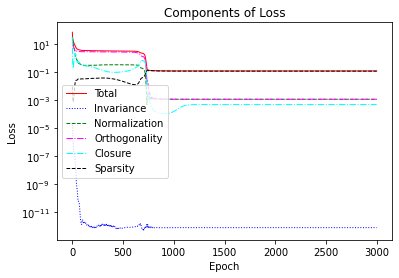

In [42]:
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot( train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.plot(comp_loss[:N,0], linewidth=1, linestyle=':',  color='b',   label='Invariance')
plt.plot(comp_loss[:N,1], linewidth=1, linestyle='--', color='g',   label='Normalization')
plt.plot(comp_loss[:N,2], linewidth=1, linestyle='-.', color='magenta', label='Orthogonality')
plt.plot(comp_loss[:N,3], linewidth=1, linestyle='-.', color='cyan', label='Closure')
plt.plot(comp_loss[:N,4], linewidth=1, linestyle='--', color='black', label='Sparsity')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

## Extract Results

In [43]:
model.eval()

with torch.no_grad():
    gens_pred, struc_pred = model(initialize_matrices,initialize_struc_const,include_sc)

#np.save('SU4_16_gen.npy',np.stack([ gens_pred[i].detach().numpy() for i in range(n_gen) ], axis =0))
#np.save('SU4_16_struc.npy',struc_pred.detach().numpy())

# Visualize Results

## View the Resulting Generator(s)

[Text(1, -1.4142135623730951, '-$\\sqrt{2}$'),
 Text(1, 0.0, '0'),
 Text(1, 1.4142135623730951, '$\\sqrt{2}$')]

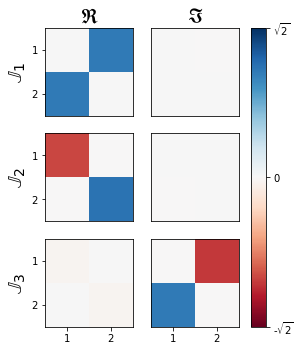

In [44]:
rows=3 #6
cols=2 #2*6
figsize=(5,5.5) #(40,12)

# Create labels for matrix rows and columns
ticks_gen_im =[]
ticks_gen_im_label = []
for i in range(n_dim):
    ticks_gen_im.append(i)
    ticks_gen_im_label.append(str(i+1))

fig,axes = plt.subplots(rows,cols,figsize=figsize)
for i,GEN in enumerate(gens_pred):
    plt.subplot(rows,cols,i*2+1)
    #if n_gen<10:
    #    print(f'Generator {i+1}: \n {GEN} \n')
    im = plt.imshow(GEN.real.detach().numpy(), cmap='RdBu', vmin=-np.sqrt(2), vmax=np.sqrt(2)) # use ax_GEN[0] with axes
    if i<9:
        plt.ylabel(r'$\mathbb{J}$'+f'$_{i+1}$',fontsize=20)
    else:
        number = str(i+1)
        plt.ylabel(r'$\mathbb{J}$'+f'$_{number[0]}$'+f'$_{number[1]}$',fontsize=20)
    if i*2<cols:
        plt.title('$\mathfrak{R}$',fontsize=20)
    if rows>1:
        if i*2>=(rows-1)*cols:
            plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        else:
            plt.xticks([])
    else:
        plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
            
    if i%(cols/2)==0:
        plt.yticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
    else:
        plt.yticks([])
            
            
    plt.subplot(rows,cols,i*2+2)
    im = plt.imshow(GEN.imag.detach().numpy(), cmap='RdBu', vmin=-np.sqrt(2), vmax=np.sqrt(2))
    if i*2<cols:
        plt.title('$\mathfrak{I}$',fontsize=20)
#         if n_gen<7:
#             det = np.linalg.det(np.eye(GEN.shape[0]) + eps * GEN.detach().numpy()) #ax_GEN[1]
#             plt.title(f'det = {det}')
#         plt.axis('off')
    if rows>1:
        if i*2>=(rows-1)*cols:
            plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        else:   #(rows*cols/2-rows-1):
            plt.xticks([])
    else:
        plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
    plt.yticks([])

# if (len(gens_pred)%2==1 and n_dim%2==0) or (len(gens_pred)%2==0 and n_dim%2==1):
#     plt.subplot(rows,cols,len(gens_pred)*2+1)
#     plt.axis('off')
#     plt.subplot(rows,cols,len(gens_pred)*2+2)
#     plt.axis('off')
            
    plt.subplots_adjust(right=0.8)
cbar = fig.colorbar(im,ax=axes.ravel().tolist(), ticks=[-np.sqrt(2), 0, np.sqrt(2)])
cbar.ax.set_yticklabels(['-$\sqrt{2}$', '0', '$\sqrt{2}$']) 
#plt.savefig('U6_6_36_00.png',bbox_inches='tight')
#plt.savefig('SU6_6_35_00.png',bbox_inches='tight')
#plt.savefig('SU2_2_3_00.png',bbox_inches='tight')

## View the Resulting Structure Constants (for $n_{gen}>1$)

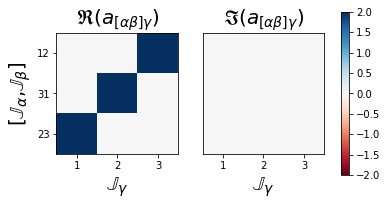

In [45]:
if include_sc and n_gen>1:
    
    figsize=(6,3)
    
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]
        
    commutator_labels = []
    if n_com==3:
        # Make the commutations cyclic for 3 generators
        for i in range(n_gen):
             for j in range(n_gen):
                    if i<j:
                        if (j-i)==2:
                            commutator_labels.append(str(j+1)+str(i+1))
                        else:
                            commutator_labels.append(str(i+1)+str(j+1))
    else:
        for i in range(n_gen):
            for j in range(n_gen):
                if i<j:
                    if n_gen>9:
                        if i<9 and j<9:
                            commutator_labels.append(str(0)+str(i+1)+str(0)+str(j+1))
                        elif i<9 and j>=9:
                            commutator_labels.append(str(0)+str(i+1)+str(j+1))
                        else:
                            commutator_labels.append(str(i+1)+str(j+1))
                    else:
                        commutator_labels.append(str(i+1)+str(j+1))
        
    ticks_com = []
    for i in range(n_com):
        ticks_com.append(i)

    ticks_gen = []
    generator_labels = []
    for i in range(n_gen):
        ticks_gen.append(i)
        generator_labels.append(str(i+1))
    
    fig,axes = plt.subplots(1,2,figsize=figsize)
    if n_com==3:
        plt.subplot(1,2,1)
        plt.imshow(struc_cyclic.real.detach().numpy(), cmap='RdBu', vmin=-2.,vmax=2.)#norm=mpl.colors.CenteredNorm())
        plt.xticks(ticks=ticks_gen,labels=generator_labels)
        plt.xlabel('$\mathbb{J}_\gamma$',fontsize=20)
        plt.yticks(ticks=ticks_com,labels=commutator_labels)
        plt.ylabel(r'$ [\mathbb{J}_\alpha$,$\mathbb{J}_\beta ] $',fontsize=20)
        plt.title(r'$\mathfrak{R}(a_{[\alpha\beta]\gamma})$',fontsize=20)
        
        plt.subplot(1,2,2)
        im = plt.imshow(struc_cyclic.imag.detach().numpy(), cmap='RdBu', vmin=-2.,vmax=2.)
        plt.xticks(ticks=ticks_gen,labels=generator_labels)
        plt.xlabel('$\mathbb{J}_\gamma$',fontsize=20)
        plt.yticks([])
        plt.title(r'$\mathfrak{I}(a_{[\alpha\beta]\gamma})$',fontsize=20)
        
    else:
        plt.subplot(1,2,1)
        plt.imshow(struc_pred.real.detach().numpy(), cmap='RdBu', vmin=-2.,vmax=2.)#norm=mpl.colors.CenteredNorm())
        plt.xticks(ticks=ticks_gen,labels=generator_labels)
        plt.xlabel('$\mathbb{J}_\gamma$',fontsize=20)
        plt.yticks(ticks=ticks_com,labels=commutator_labels)
        plt.ylabel(r'$ [\mathbb{J}_\alpha$,$\mathbb{J}_\beta ] $',fontsize=20)
        plt.title(r'$\mathfrak{R}(a_{[\alpha\beta]\gamma})$',fontsize=20)
        
        plt.subplot(1,2,2)
        im = plt.imshow(struc_pred.imag.detach().numpy(), cmap='RdBu', vmin=-2.,vmax=2.)
        plt.xticks(ticks=ticks_gen,labels=generator_labels)
        plt.xlabel('$\mathbb{J}_\gamma$',fontsize=20)
        plt.yticks([])
        plt.title(r'$\mathfrak{I}(a_{[\alpha\beta]\gamma})$',fontsize=20)
        
    plt.colorbar(im, ax=axes.ravel().tolist())
    
    # add grid lines
    # for i in range(n_gen-1):
    #     plt.axvline(x=1/2+i, linewidth=1, color ='black')
    # for i in range(n_com-1):
    #     plt.axhline(y=1/2+i-0.01, linewidth=1, color ='black')


# Verify Results

## Verify the Structure Constants Produce an Algebra (for $n_{gen}>1$)

In [46]:
if include_sc and n_gen>1:
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]

    comm_index = 0
    Cs = []
    for i,G in enumerate(gens_pred):
        for j,H in enumerate(gens_pred):
            if i<j and n_gen!=3:
                C1 = bracket(G,H)
                C2 = 0
                for k,K in enumerate(gens_pred):
                    C2 += struc_pred[comm_index,k]*K
                C = C1 - C2
                error = torch.mean(torch.abs(C))
                print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_pred[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                if error<1e-1:
                    print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                elif error>1e-1:
                    print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n')
                Cs.append(C)
                comm_index+=1
            # Make the cyclic commutators if n_gen = 3   
            elif i<j and n_gen==3:
                if (j-i)==2:
                    C1 = bracket(H,G)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C))
                    print(str(j+1)+str(i+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    if error<1e-1:
                        print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                    elif error>1e-1:
                        print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
                else:
                    C1 = bracket(G,H)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C))
                    print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    if error<1e-1:
                        print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}. \n \n')
                    elif error>1e-1:
                        print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
    
    
    # Calculate the total MSE in finding the structure constants
    tot_error = 0.
    for i,C in enumerate(Cs):
        tot_error+=torch.mean(torch.abs(C))
    print(f'Total MAE = {tot_error}')
    # if error < 1e-1:
    #     print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}.')
    # else:
    #     print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}.')

12: 
 Structure Constants = [-2.3841858e-07+1.4901161e-08j  3.4434348e-04+0.0000000e+00j
  1.9866810e+00+0.0000000e+00j]
 
 C = 
  [[ 0.07345673-2.0638455e-04j  1.9782473 +1.9757763e+00j]
 [-1.978247  -1.9757766e+00j  0.06610309+2.0638421e-04j]] 

The structure constants were NOT found successfully with a mean absolute error (MAE) of 1.4328488111495972. 
 

31: 
 Structure Constants = [1.1175871e-08-3.0850060e-09j 1.9863355e+00-1.8626451e-09j
 3.4433976e-04+7.4505806e-09j]
 
 C = 
  [[ 1.8762097 -1.9792831e+00j -0.00334049+1.3647068e-04j]
 [ 0.00334045-1.3646237e-04j -2.0725896 +1.9792831e+00j]] 

The structure constants were NOT found successfully with a mean absolute error (MAE) of 1.3999429941177368. 
 

23: 
 Structure Constants = [ 1.9868777e+00-9.3057752e-06j  2.2824109e-04-5.6698918e-06j
 -3.0045470e-03-1.5065074e-05j]
 
 C = 
  [[ 1.0498632e-04-5.9795643e-06j -1.9771340e+00+1.9740914e+00j]
 [-1.9771638e+00+1.9800674e+00j -3.3865863e-04+5.3694380e-06j]] 

The structure constants

## Verify Orthogonality (for $n_{gen}>1$)

In [47]:
def get_angle(v, w):
    # Angle between vectors
    return torch.arccos( (v @ w.conj()).real / ( torch.norm(v.abs()) * torch.norm(w.abs()) ) )

def get_axis(M):
    # Finds the eigenvector with min(Imaginary(eigenvalue))
    # if the matrix is a rotation matrix or a generator of rotation,s then this vector is the axis of rotation  
    eig_vals, eig_vecs = torch.linalg.eig(M)
    # find the minimum arg of the minimum imaginary component
    # pass that to the transposed eigenvector array to pull the eigenvector
    axis = eig_vecs.T[torch.argmin(torch.abs(eig_vals.imag))]
    # Change to more positive than negative values in axis vector by multiplying by the net sign
    return torch.sign(torch.sum(axis).real)*axis

In [48]:
for i,G in enumerate(gens_pred):
    for j,H in enumerate(gens_pred):
        if i<j:
            angle = get_angle(get_axis(G), get_axis(H))
            angle_deg = 180/np.pi*float(angle)
            print(f'Angle between generator {i+1} and {j+1}: {angle:>.10f} rad, {angle_deg:>.10f} deg')

Angle between generator 1 and 2: 0.7853981256 rad, 44.9999978371 deg
Angle between generator 1 and 3: 1.0467104912 rad, 59.9720935167 deg
Angle between generator 2 and 3: 1.5707963705 rad, 90.0000025045 deg
